#### Program to create image with correlated noise for AEGIS using empty regions
6 empty regions in the AEGIS fileds (in V and I bands) were visually idenitified and thier information was saved in empty_fields.txt. The empty feilds are picked from different regions and have varying sizes. Correlation function is computed for each of these files. The mean in each band is then used to create a noise field



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyfits
import galsim
from astropy.table import Table
%matplotlib inline

In [2]:
rng = galsim.BaseDeviate(123456)
# read file containing location and names of AEGIS fields with empty region
e_file = Table.read('empty_fields.txt', format='ascii.basic')

In [3]:
## Get empty fields and compute correlation function
filters = ['f814w', 'f606w']
filter_file_names = ['I', 'V']
xis={}
xis_log = {}
em_field={}
q={}
for f, filt in enumerate(filters):
    xis[filt]=[]
    xis_log[filt]=[]
    em_field[filt] = []
    q[f], = np.where(e_file['FILTER']== filt) 
    for i,num in enumerate(q[f]):
        file_name = e_file['FILE'][num]
        dat1= pyfits.open(file_name)[0].data 
        x1,x2 = e_file['XMIN'][num], e_file['XMAX'][num]
        y1,y2 = e_file['YMIN'][num], e_file['YMAX'][num]
        dat2 = dat1[y1:y2, x1:x2]
        em_field[filt].append(dat2)
        img=galsim.Image(dat2)
        cn = galsim.CorrelatedNoise(img, rng=rng, scale=0.03)
        image = galsim.ImageD(50, 50, scale=0.03)
        xi = cn.drawImage(image)
        xis_log[filt].append(np.log10(np.abs(xi.array/np.max(xi.array))))
        xis[filt].append(xi.array)

### View empty reigions

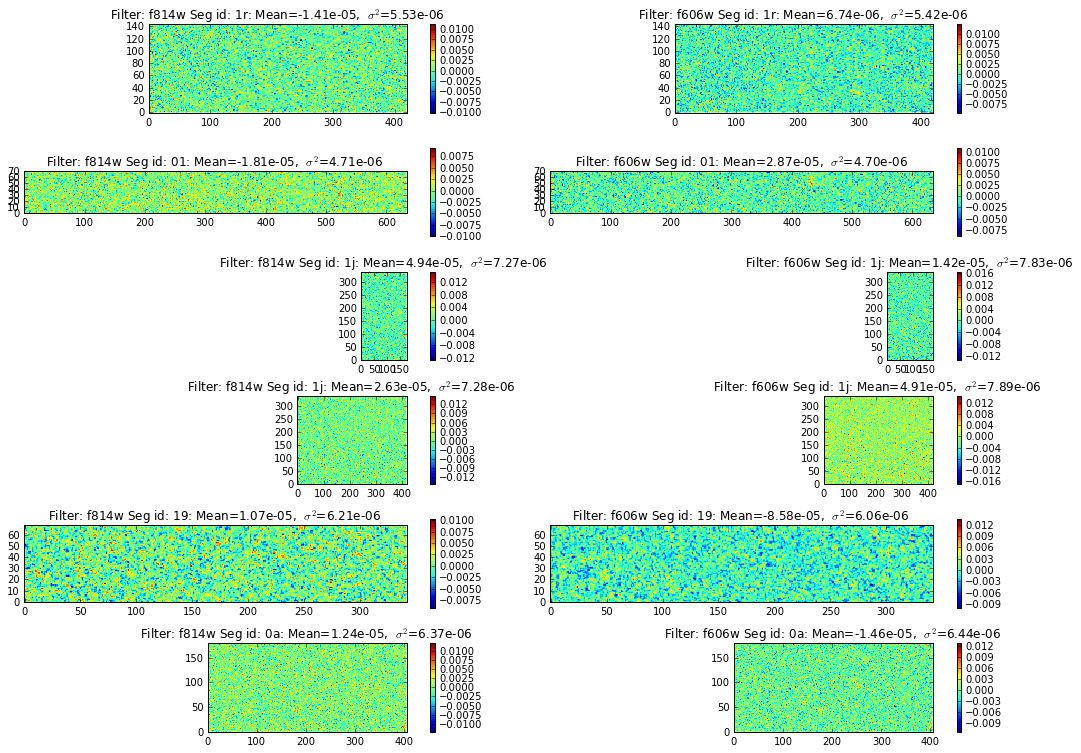

In [4]:
plt.figure(1,figsize=[18,26])
plt.subplots_adjust(wspace = 0.1)
plt.subplots_adjust(hspace = 0.4)
count=1
for f, filt in enumerate(filters):
    for i,num in enumerate(q[f]):
        plt.subplot(2*len(q[f]),2,2*i+f+1)
        plt.imshow(em_field[filt][i], interpolation ='none', origin='lower')
        plt.colorbar()
        plt.title('Filter: '+ filt + ' Seg id: '+ e_file['SEG'][num]+': Mean={0:0.2e},  $\sigma^2$={1:0.2e} '.format(np.mean(em_field[filt][i]), np.var(em_field[filt][i])))
        #plt.clim([-0.02,0.02])
        count+=1
        

### View Covariance Matrix 
## $$log10(\xi/max(\xi))$$

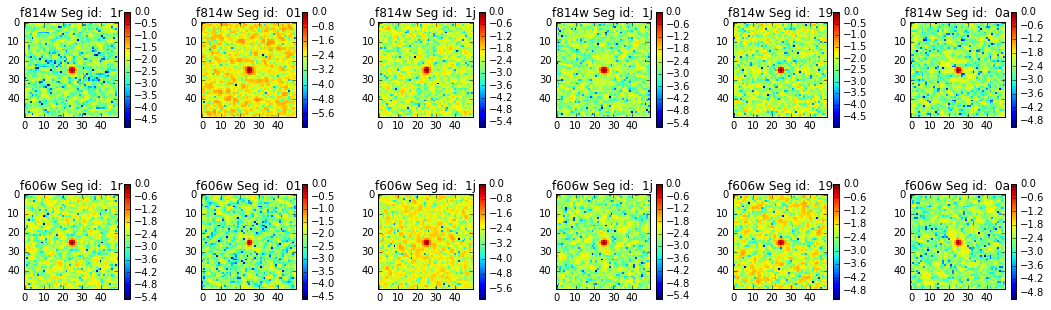

In [5]:
plt.figure(1,figsize=[18,36])
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)
count=1
for f, filt in enumerate(filters):
    for i,num in enumerate(q[f]):
        plt.subplot(12,6,6*f+i+1)
        plt.imshow(xis_log[filt][i], interpolation ='none')
        plt.colorbar()
        plt.title(filt + ' Seg id: '+ ' '+ e_file['SEG'][q[f][i]])
        #plt.clim([-5.4,0])
        count+=1
#plt.suptitle('$log10(\\xi/max(\\xi))$')

### View horizontal cross section at center

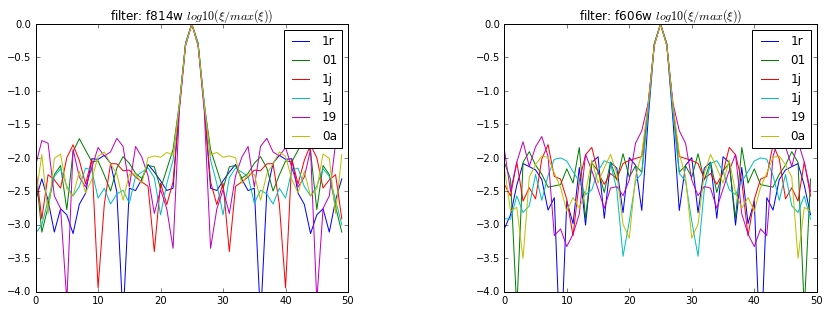

In [6]:
plt.figure(1,figsize=[14,12])
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)

for f, filt in enumerate(filters):
    for i,num in enumerate(q[f]):
        s = xis_log[filt][i].shape
        plt.subplot(2,2,f+1)
        plt.title('filter: '+filt +' $log10(\\xi/max(\\xi))$')
        plt.plot(xis_log[filt][i][s[0]/2,:], label= e_file['SEG'][q[f][i]])
        plt.ylim([-4,0])
    plt.legend()

### Mean Correlation Function

Overwriting existing file 'acs_I_unrot_sci_20_cf.fits'.
Overwriting existing file 'acs_V_unrot_sci_20_cf.fits'.


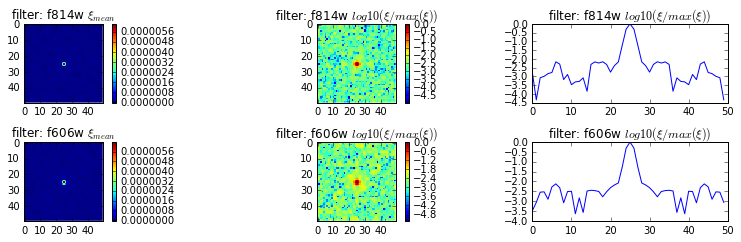

In [13]:
mean_xi = {}
mean_xi_log = {}

plt.figure(1,figsize=[14,12])
plt.subplots_adjust(wspace = 0.5)
plt.subplots_adjust(hspace = 0.5)

for f, filt in enumerate(filters):
    mean_xi[filt] = np.mean(xis[filt], axis=0)
    mean_xi_log[filt]=np.log10(np.abs(mean_xi[filt]/np.max(mean_xi[filt])))
    cf_name = 'acs_filter_unrot_sci_20_cf.fits'.replace('filter', filter_file_names[f])
    pyfits.writeto(cf_name, mean_xi[filt], clobber=True)
    plt.subplot(6,3,3*f+1)
    plt.title('filter: '+filt +' $\\xi_{mean}$')
    plt.imshow(mean_xi[filt], interpolation ='none')
    plt.colorbar()
    plt.subplot(6,3,3*f+2)
    plt.title('filter: '+filt +' $log10(\\xi/max(\\xi))$')
    plt.imshow(mean_xi_log[filt], interpolation ='none')
    plt.colorbar()
    plt.subplot(6,3,3*f+3)
    s = mean_xi_log[filt].shape
    plt.title('filter: '+filt +' $log10(\\xi/max(\\xi))$')
    plt.plot(mean_xi_log[filt][s[0]/2,:], label= e_file['SEG'][q[f][i]])
    #plt.clim([-5.4,0])


### View noise image
    

In [ ]:
plt.figure(1,figsize=[24,18])
plt.subplots_adjust(wspace = 0.3)
plt.subplots_adjust(hspace = 0.3)
for f, filt in enumerate(filters):    
    cf_name = 'acs_I_unrot_sci_20_cf.fits'.replace('filter', filter_file_names[f])
    noise = galsim.getCOSMOSNoise(file_name = cf_name, rng=rng)
    noise_image = galsim.Image(300, 300)
    noise = galsim.getCOSMOSNoise(rng=rng)
    noise_image.addNoise(noise)
    plt.subplot(2,2,f+1)
    img = noise_image.array
    plt.title('filter: '+filt +', Mean={0:0.2e},  $\sigma^2$={1:0.2e} '.format(np.mean(img), np.var(img)))
    plt.imshow(img, cmap='Greys_r')
    plt.colorbar()
    noise_name = 'test_aeg_filter_noise.fits'.replace('filter', filter_file_names[f])
    pyfits.writeto(noise_name, img, clobber=True)